# HySwash: A hybrid method for nearshore wave processes

Table of Contents
* [1. Clustering and selection method](#1.-Clustering-and-selection-method)
	* [1.1 LHS sampling](#1.1-LHS-sampling)
	* [1.2 MDA algorithm](#1.2-MDA-algorithm)<br><br>
    
* [2. Numerical model SWASH](#2.-Numerical-model-SWASH)
	* [2.1 Data preprocessing](#2.1-Data-preprocessing)   
		* [2.1.1 Cross-shore profile](#2.1.1-Cross-shore-profile)
		* [2.1.2 Friction](#2.1.2-Friction)     
		* [2.1.3 Vegetation](#2.1.3-Vegetation) 
	* [2.2. Boundary conditions](#2.2-Boundary-conditions)
		* [2.2.1 Sea state](#2.2.1-Sea-state)
		* [2.2.2 Wind](#2.2.2-Wind)
	* [2.3. Run](#2.3-Run)
	* [2.4. Data Postprocessing](#2.4.-Data-Postprocessing)<br><br>
    
* [3. Time series reconstruction RBF](#3.-Time-series-reconstruction-RBF)
<br><br>

In [1]:
import sys
import os
import os.path as op

sys.path.insert(0, op.join(os.getcwd(), "hySwash"))

## Latine Hypercube Sampling

In [2]:
from bluemath_tk.datamining.lhs import LHS

lhs_parameters = {
    'num_dimensions': 3,
    'num_samples': 10000,
    'dimensions_names': ['Hs', 'Hs_L0', 'VegetationHeight'],
    'lower_bounds': [0.5, 0.005, 0],
    'upper_bounds': [3, 0.05, 1.5],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"), 
    num_samples=lhs_parameters.get("num_samples"),
)
df_dataset = lhs.fit(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
)

## Clustering & Selection Method MDA

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v1}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

2024-11-11 11:55:52,636 - MDA - INFO - 
mda parameters: 10000 --> 5

2024-11-11 11:55:52,636 - MDA - INFO - 
mda parameters: 10000 --> 5

2024-11-11 11:55:52,638 - MDA - INFO - Normalizing data to range 0-1 using min max scaler approach
2024-11-11 11:55:52,638 - MDA - INFO - Normalizing data to range 0-1 using min max scaler approach
2024-11-11 11:55:52,642 - MDA - INFO -    MDA centroids: 2/5
2024-11-11 11:55:52,642 - MDA - INFO -    MDA centroids: 2/5
2024-11-11 11:55:52,644 - MDA - INFO -    MDA centroids: 3/5
2024-11-11 11:55:52,644 - MDA - INFO -    MDA centroids: 3/5
2024-11-11 11:55:52,645 - MDA - INFO -    MDA centroids: 4/5
2024-11-11 11:55:52,645 - MDA - INFO -    MDA centroids: 4/5
2024-11-11 11:55:52,646 - MDA - INFO -    MDA centroids: 5/5
2024-11-11 11:55:52,646 - MDA - INFO -    MDA centroids: 5/5


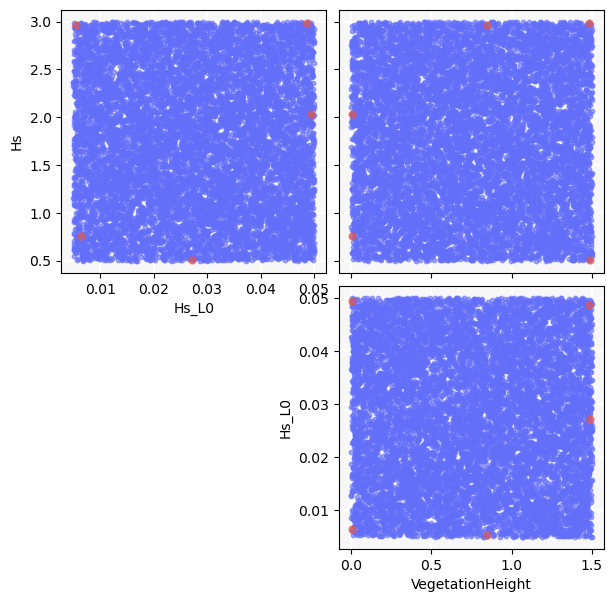

In [3]:
from bluemath_tk.datamining.mda import MDA
from lib.MDA import scatter_mda

mda_parameters = {
    'num_centers': 5
}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
df_subset = mda.fit(data=df_dataset)

fig = scatter_mda(
    data_samples=[df_dataset, df_subset], 
    names=lhs_parameters.get("dimensions_names"),
    figsize=(7, 7)
)

## Numerical model SWASH

In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region.

In [4]:
import numpy as np

from wrap_swash.wswash.wrap import SwashProject, SwashInput, SwashWrap
from wrap_swash.wswash.plots import SwashPlot
from wrap_swash.wswash.postprocessor import Postprocessor

from lib.waves import  series_TMA

p_proj = "/home/tausiaj/GitHub-GeoOcean/swash/projects/"
n_proj = "test_javi_5"

# Initialize the project
extra_parameters_for_project = {
    'tendc': 3600,
    'cf': 0.01,
    'vert': 5,
    'depth': '/home/tausiaj/GitHub-GeoOcean/swash/testcase/depth.bot'
}
sp = SwashProject(p_proj, n_proj, extra_parameters=extra_parameters_for_project)
sw = SwashWrap(sp)
si = SwashInput()
sm = SwashPlot(sp)

def make_swash_input(swash_cases_parameters, sp):
    swash_cases_parameters['H'] = swash_cases_parameters['Hs']
    swash_cases_parameters['T'] = np.sqrt((swash_cases_parameters['Hs'].values * 2 * np.pi) / (9.806 * swash_cases_parameters['Hs_L0']))
    swash_cases_parameters['gamma'] = 2
    swash_cases_parameters['warmup'] = sp.warmup
    swash_cases_parameters['deltat'] = sp.deltat
    swash_cases_parameters['tendc'] = sp.tendc
    swash_cases_parameters['WL'] = 1
    swash_cases_parameters['height'] = swash_cases_parameters['VegetationHeight']
    swash_input = []
    i=0
    for iw, waves in swash_cases_parameters.iterrows():
        series = series_TMA(waves, sp.depth[0]) # PABLO: ¿qué significa el depth[0]?
        si.waves_parameters = waves
        si.waves_series = series
        si.height =  swash_cases_parameters['height'][i]
        swash_input.append(si)
        i = i + 1
    return swash_input

swash_input = make_swash_input(df_subset, sp)

waves = sw.build_cases(swash_input)

## Run cases

In the following, a series of predefined options have been choosen: <br></span>

* Grid resolution is determined through a number of points per wavelength criteria: Courant number for numerical stability, number of points per wavelength, and manual upper and lower limits for grid cell sizes.

* The default value for the maximun wave breaking steepness parameter is $ \alpha = 0.6$.

* For high, nonlinear waves, or wave interaction with structures with steep slopes (e.g. jetties, quays), a Courant number of 0.5 is advised. Here, a dynamically adjusted time step controlled by a Courant number range of (0.1 - 0.5) is implemented.

User parametes:

* `Nonhydrostatic` : to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant.
* `vert` : this command set the number of vertical layers in case that the run will be in multi-layered mode.

In [ ]:
# Run cases
# sw.run_cases()

SWASH CASE: 0000 SOLVED
SWASH CASE: 0001 SOLVED
SWASH CASE: 0002 SOLVED
SWASH CASE: 0003 SOLVED
SWASH CASE: 0004 SOLVED


In [ ]:
# convert raw SWASH output to netcdf files
# sw.output_files()

SWASH CASE: /home/tausiaj/GitHub-GeoOcean/swash/projects/test_javi_5/0000 POSTPROCESSED
SWASH CASE: /home/tausiaj/GitHub-GeoOcean/swash/projects/test_javi_5/0001 POSTPROCESSED
SWASH CASE: /home/tausiaj/GitHub-GeoOcean/swash/projects/test_javi_5/0002 POSTPROCESSED
SWASH CASE: /home/tausiaj/GitHub-GeoOcean/swash/projects/test_javi_5/0003 POSTPROCESSED
SWASH CASE: /home/tausiaj/GitHub-GeoOcean/swash/projects/test_javi_5/0004 POSTPROCESSED


In [5]:
# Define variables to compute
output_vars = ['Ru2', 'Msetup', 'RuDist', 'Hrms', 'Hfreqs']

# Initialize the postprocessor
pp = Postprocessor(sp, si, sw, output_vars=output_vars, run_post=False)

In [6]:
# pp.ds_output.to_netcdf("../testcase/javi_output_example.nc")

In [7]:
pp.ds_output

<xarray.Dataset> Size: 520kB
Dimensions:  (case_id: 5, Tsec: 3600, Xp: 1400)
Coordinates:
  * case_id  (case_id) float64 40B 0.0 1.0 2.0 3.0 4.0
  * Tsec     (Tsec) float64 29kB 540.0 541.0 542.0 ... 4.138e+03 4.139e+03
  * Xp       (Xp) float64 11kB 0.0 1.0 2.0 3.0 ... 1.397e+03 1.398e+03 1.399e+03
    Yp       float64 8B 0.0
Data variables:
    Ru2      (case_id) float64 40B 4.097 4.097 4.097 4.097 4.097
    Runlev   (case_id, Tsec) float64 144kB 2.058 1.678 1.192 ... 0.5878 0.7356
    Msetup   (case_id, Xp) float64 56kB 0.01126 0.01078 0.01016 ... 8.164 8.162
    Hrms     (case_id, Xp) float64 56kB 12.51 12.52 12.5 12.54 ... nan nan nan
    Hs       (case_id, Xp) float64 56kB 3.128 3.125 ... 6.486e-15 6.486e-15
    Hss      (case_id, Xp) float64 56kB 3.077 3.074 ... 2.353e-18 2.353e-18
    ig       (case_id, Xp) float64 56kB 0.4937 0.4937 ... 6.486e-15 6.486e-15
    Hvlf     (case_id, Xp) float64 56kB 0.09933 0.09918 ... 6.072e-15 6.072e-15

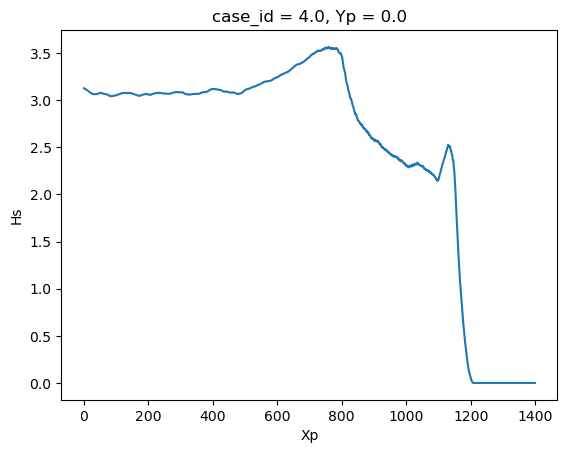

In [8]:
import matplotlib.pyplot as plt
pp.ds_output.Hs.isel(case_id=4).plot()

## Cross-shore profile

Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible kh < 5. As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. 
 
* `dxL`  : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). 

* `dxinp`: The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible.

{'fontsize': 15, 'figure_width': 6.4, 'figure_height': 2.1333333333333333}


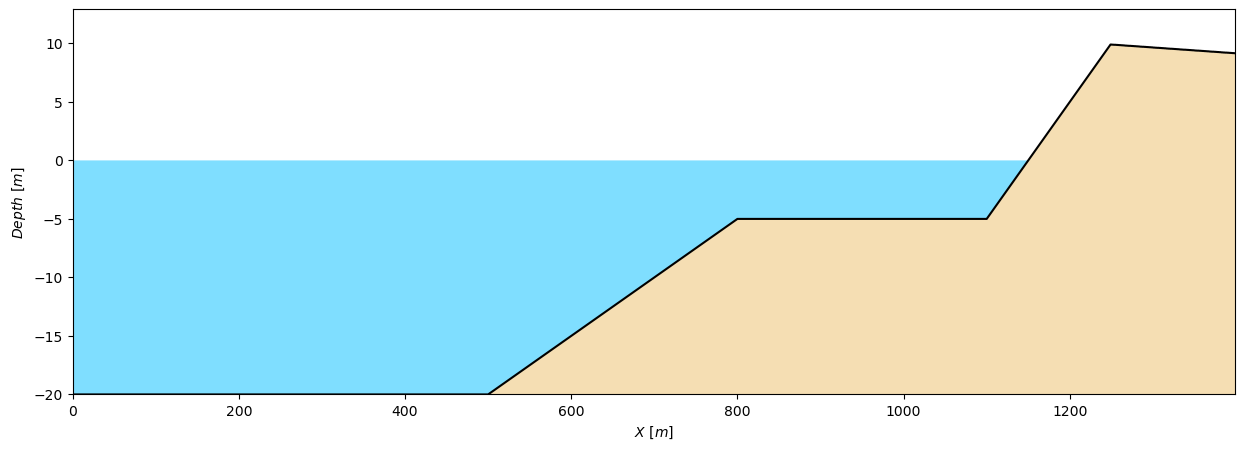

In [9]:
fig = sm.plot_depthfile()

In [10]:
from IPython.display import HTML

case = 0
ani = sm.animate_case_propagation(sp, case, tini=100, tend=200, tstep=4, figsize=(15,5))
HTML(ani.to_jshtml())

Range sigma 0.0010-0.1000 - Opt sigma 0.0853


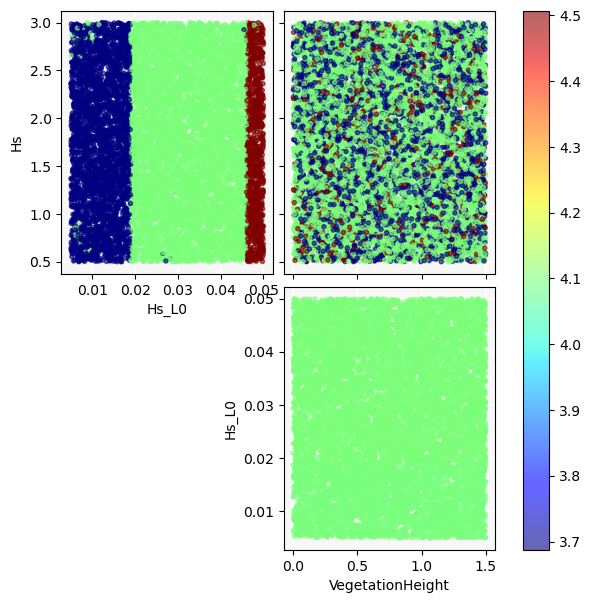

In [13]:
from lib.reconstruction import RBF_Reconstruction_singular
from lib.output_extract import scatter_color

# Sinular Reconstruction
var = ['Ru2']

ix_scalar_subset = [0, 1, 2]
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []

# RBF reconstruction
df_output = RBF_Reconstruction_singular(
    pp, var, lhs_parameters.get("dimensions_names"), 
    df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target
)

fig = scatter_color(df_dataset, df_output, lhs_parameters.get("dimensions_names"), var, figsize=(7,7), vmin=None, vmax=None, cmap='jet')

Range sigma 0.0010-0.1000 - Opt sigma 0.0311


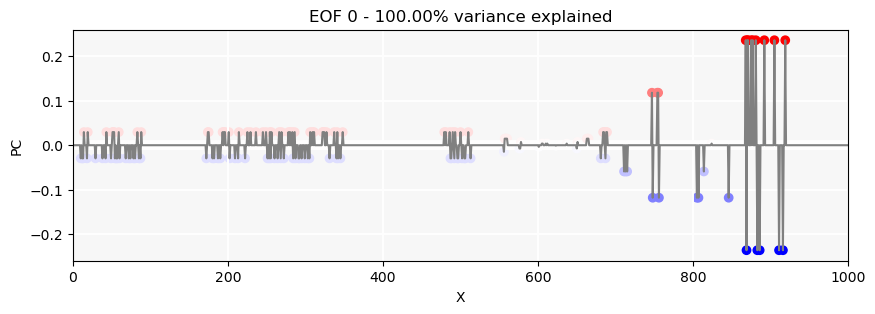

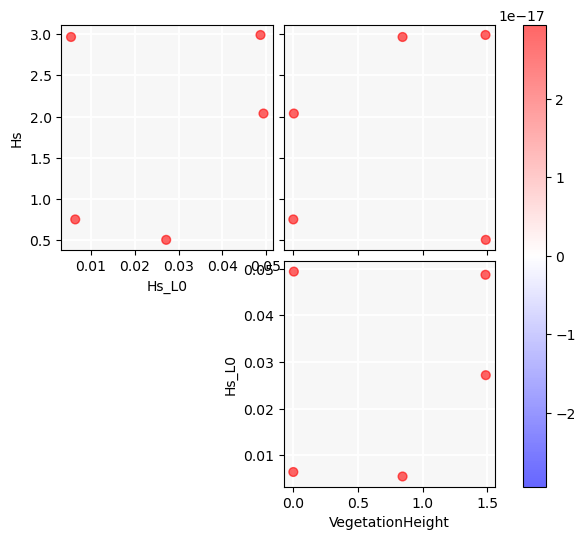

In [15]:
from lib.reconstruction import RBF_Reconstruction_spatial
from lib.PCA import plot_PCA

# Spatial Reconstruction
var = ['Msetup']                 # variable to reconstruct
X_max = 1000                     # maximum spatial X to consider for PCA
variance = 99                    # maximum variance to explain

ix_scalar_subset = [0, 1, 2]    
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []

# Compute PCA and apply RBF recosntruction
xds_PCA, ds_output = RBF_Reconstruction_spatial(
    pp, var, lhs_parameters.get("dimensions_names"), 
    df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target, variance, X_max
)

plot_PCA(xds_PCA, df_subset, lhs_parameters.get("dimensions_names"), figsize1=(6+1,6), figsize2=(10,3))